In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
import os

In [2]:
MIN_MATCH_COUNT = 4

In [3]:
def load_img(imgName1, imgName2):
    img1 = cv2.imread(imgName1)  # trainImage
    img2 = cv2.imread(imgName2)  # queryImage
    return img1, img2

In [4]:
def averaging(result, x_min, y_min, img2, region=5, blur_size=10):
    blur = cv2.blur(result, (blur_size, blur_size))
    # left
    if (-x_min-region) < 0:
        result[-y_min:-y_min + img2.shape[0], -x_min:-x_min+region] = blur[-y_min:-y_min + img2.shape[0], -x_min:-x_min+region]
    else:
        result[-y_min:-y_min + img2.shape[0], -x_min-region:-x_min+region] = blur[-y_min:-y_min + img2.shape[0], -x_min-region:-x_min+region]
    # right
    if (-x_min+img2.shape[1]+region) > (result.shape[1] - 1):
        result[-y_min:-y_min+img2.shape[0], -x_min+img2.shape[1]-region:-x_min+img2.shape[1]] = blur[-y_min:-y_min + img2.shape[0], -x_min+img2.shape[1]-region:-x_min+img2.shape[1]]
    else:
        result[-y_min:-y_min+img2.shape[0], -x_min+img2.shape[1]-region:-x_min+img2.shape[1]+region] = blur[-y_min:-y_min + img2.shape[0], -x_min+img2.shape[1]-region:-x_min+img2.shape[1]+region]
    # up
    if (-y_min-region) < 0:
        result[-y_min:-y_min+region, -x_min:-x_min+img2.shape[1]] = blur[-y_min:-y_min+region, -x_min:-x_min+img2.shape[1]]
    else:
        result[-y_min-region:-y_min+region, -x_min:-x_min+img2.shape[1]] = blur[-y_min-region:-y_min+region, -x_min:-x_min+img2.shape[1]]
    # down
    if (-y_min+img2.shape[0]+region) > (result.shape[0] - 1):
        result[-y_min+img2.shape[0]-region:-y_min+img2.shape[0], -x_min:-x_min+img2.shape[1]] = blur[-y_min+img2.shape[0]-region:-y_min+img2.shape[0], -x_min:-x_min + img2.shape[1]]
    else:
        result[-y_min+img2.shape[0]-region:-y_min+img2.shape[0]+region, -x_min:-x_min + img2.shape[1]] = blur[-y_min+img2.shape[0]-region:-y_min+img2.shape[0]+region, -x_min:-x_min + img2.shape[1]]

    return result

In [5]:
def gaus_pyramid(img, size):
    G = img.copy()
    gp = [G]
    for i in range(size):
        G = cv2.pyrDown(G)
        gp.append(G)
    
    return gp

In [6]:
def lap_pyramid(gp, size):
    lp = [gp[size-1]]
    for i in range(size-1,0,-1):
        GE = cv2.pyrUp(gp[i], dstsize=(gp[i-1].shape[1], gp[i-1].shape[0]))
        L = cv2.subtract(gp[i-1], GE)
        lp.append(L)
    
    return lp

In [7]:
def blending(pysize, img1_homo, img2, x_min, y_min):
    pysize = pysize
    # generate Gaussian pyramid for A and B
    gpA = gaus_pyramid(img1_homo, pysize)
    gpB = gaus_pyramid(img2, pysize)

    # generate Laplacian Pyramid for A and B
    lpA = [gpA[pysize-1]]
    lpA = lap_pyramid(gpA, pysize)
    lpB = [gpB[pysize-1]]
    lpB = lap_pyramid(gpB, pysize)

    # Now add the images in each level
    LS = []
    count = 0
    for la,lb in zip(lpA,lpB):
        rows, cols, dpt = la.shape
        py_ymin = int(y_min/(pow(2, pysize-1-count)))
        py_xmin = int(x_min/(pow(2, pysize-1-count)))
        img2_pad = la.copy()
        img2_pad[-py_ymin:-py_ymin + lb.shape[0], -py_xmin:-py_xmin + lb.shape[1]] = lb
        count += 1
        LS.append(img2_pad)

    # now reconstruct
    ls_ = LS[0]
    for i in range(1, pysize):
        ls_ = cv2.pyrUp(ls_, dstsize=(LS[i].shape[1], LS[i].shape[0]))
        ls_ = cv2.add(ls_, LS[i])
    
    return ls_

In [8]:
def dlt(f, t, num_points=4):
    """	Returns Homography matrix in which 'f' points are mapped to 't' points
        using Direct Linear Transform algorithm.
        t = Hf
    """
    assert f.shape == t.shape
    num_points = f.shape[0]
    A = np.zeros((2*num_points, 9))
    for p in range(num_points):
        fh = np.array([f[p,0], f[p,1], 1])										# Homogenous coordinate of point p
        A[2*p + 1] = np.concatenate(([0, 0, 0], -fh, t[p,1]*fh))					# [0' -wX' yX']
        A[2*p ] = np.concatenate((-fh, [0, 0, 0], t[p,0]*fh))				# [wX' 0' -xX']
    U, D, V = np.linalg.svd(A)
    H = V[8].reshape(3, 3)
    return H / H[-1,-1]        

In [9]:
def ransac(kp1,kp2,num_matches, threshold_distance=0.1, threshold_inliers=0, ransac_iters=50):
    HOMO_new=np.zeros((3,3))
    for it in range(ransac_iters):
        indexes = random.sample(range(num_matches), 4)         # Randomly select four points
        fp = np.array([kp1[pt] for pt in indexes])
        tp = np.array([kp2[pt] for pt in indexes])
        homography = dlt(fp, tp)        # tp = H*fp
        src_pts = np.insert(kp1, 2, 1, axis=1).T # Add column of 1 at the end (Homogenous coordinates)
        dst_pts = np.insert(kp2, 2, 1, axis=1).T # Add column of 1 at the end (Homogenous coordinates)
        projected_pts = np.dot(homography, src_pts)
        error = np.sqrt(np.sum(np.square(dst_pts - (projected_pts/projected_pts[-1])), axis=0))
        if np.count_nonzero(error < threshold_distance) > threshold_inliers:
            src_inliers = src_pts[:, np.argwhere(error < threshold_distance).flatten()][:-1].T
            dst_inliers = dst_pts[:, np.argwhere(error < threshold_distance).flatten()][:-1].T
            HOMO_new = homography
            num_inliers = np.count_nonzero(error < threshold_distance)
            threshold_inliers = num_inliers
#             print(threshold_inliers)
    return HOMO_new


In [10]:
def AutoStitch (img1,img2, draw_match=False):
    
    # Transform to RGB
    #img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    #img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    #plt.imshow(img2)
    #plt.show()
    sift = cv2.xfeatures2d.SIFT_create()
    
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
        
    matches = flann.knnMatch(des1,des2,k=2)


    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    print('good matches: ',len(good))


    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,2)

        # findHomography finds the perspective transformation matrix M of src with respect to dst.
        M_cal = ransac(src_pts,dst_pts,len(good), threshold_distance=4, threshold_inliers=0, ransac_iters=1000)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        print("M_cal:\n", M_cal)
        print("M_real:\n", M)
        h, w, d = img1.shape
        h2, w2, d2 = img2.shape
        pts1 = np.float32([ [0,0],[0,h],[w,h],[w,0]]).reshape(-1,1,2)
        pts2 = np.float32([ [0,0],[0,h2],[w2,h],[w2,0]]).reshape(-1,1,2)
        dst1 = cv2.perspectiveTransform(pts1,M_cal)
#         dst1 = cv2.perspectiveTransform(pts1,M)
    else:
        print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
        matchesMask = None
        
    # Resulting dimensions
    result_dims = np.concatenate((dst1, pts2), axis=0)
    
    # Getting images together
    # Calculate dimensions of match points
    [x_min, y_min] = np.int32(result_dims.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(result_dims.max(axis=0).ravel() + 0.5)
    
    # shifting the coordinate system such that the coordinate are greater than 0.
    # Shifting = transform_array.dot(M), where M is the homography matrix of src with respect to dst.
    transform_dist = [-x_min, -y_min]
    transform_array = np.array([[1, 0, transform_dist[0]],
                                                 [0, 1, transform_dist[1]],
                                                 [0, 0, 1]])
    
    result = cv2.warpPerspective(img1, transform_array.dot(M), (x_max-x_min, y_max-y_min))

    if draw_match:
                # draw the correspondence        
        draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                            singlePointColor=True,
                            #matchesMask=matchesMask,  # draw only inliers
                            flags=2)
        img1_match = img1.copy()
        img2_match = img2.copy()
        match_img = cv2.drawMatches(img1_match, kp1, img2_match, kp2, good, None, **draw_params)
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
        ax[0][0].imshow(img1)
        ax[0][1].imshow(img2)
        shifted_x = result.shape[1] - img2.shape[1]
        img1_homo = result.copy()
#         result = blending(5, img1_homo, img2, x_min, y_min)
        result[-y_min:-y_min + img2.shape[0], -x_min:-x_min + img2.shape[1]] = img2
        avg_result = result.copy()
        avg_result = averaging(avg_result, x_min, y_min, img2, region=20, blur_size=20)
        ax[1][0].imshow(match_img)
        ax[1][1].imshow(avg_result)
    else:
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
        ax[0].imshow(img1)
        ax[1].imshow(img2)
        shifted_x = result.shape[1] - img2.shape[1]
#         img1_homo = result.copy()
#         pyr_result = blending(5, img1_homo, img2, x_min, y_min)
        result[-y_min:-y_min + img2.shape[0], -x_min:-x_min + img2.shape[1]] = img2
        avg_result = result.copy()
        avg_result = averaging(avg_result, x_min, y_min, img2, region=20, blur_size=20)
        ax[2].imshow(avg_result)
        
    plt.tight_layout()
    print('-' * 100)
    
    return avg_result

2.jpg
good matches:  599
M_cal:
 [[  9.88820721e-01   3.87136601e-02   2.71978457e+02]
 [ -4.45508532e-02   1.01450223e+00   1.35279356e+01]
 [ -3.39612274e-05   9.11543592e-06   1.00000000e+00]]
M_real:
 [[  9.97771117e-01   4.24227030e-02   2.71641732e+02]
 [ -4.51601029e-02   1.02838361e+00   1.06690360e+01]
 [ -3.20972801e-05   2.03023444e-05   1.00000000e+00]]
----------------------------------------------------------------------------------------------------
3.jpg
good matches:  285
M_cal:
 [[  9.45359949e-01  -9.28497840e-03   6.64252211e+02]
 [ -6.74506849e-02   1.00069158e+00   4.70517119e+01]
 [ -6.55128163e-05  -1.99504706e-05   1.00000000e+00]]
M_real:
 [[  1.01263636e+00   1.57967839e-01   6.24014584e+02]
 [ -6.88615356e-02   1.12120031e+00   2.26135734e+01]
 [ -6.68820301e-05   1.12277757e-04   1.00000000e+00]]
----------------------------------------------------------------------------------------------------
4.jpg
good matches:  285
M_cal:
 [[  1.00097916e+00   2.663005

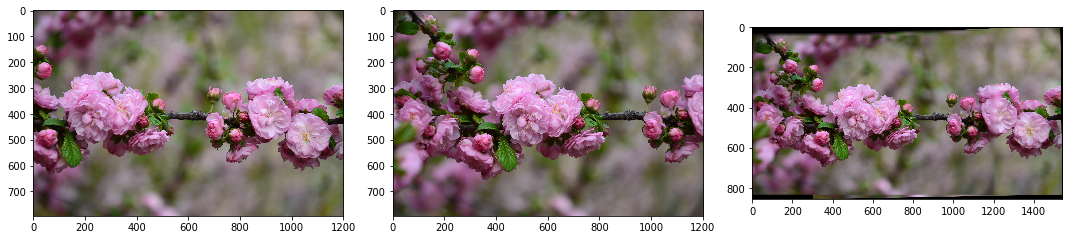

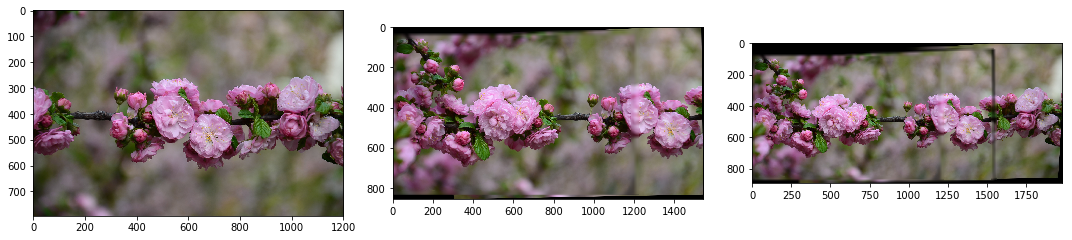

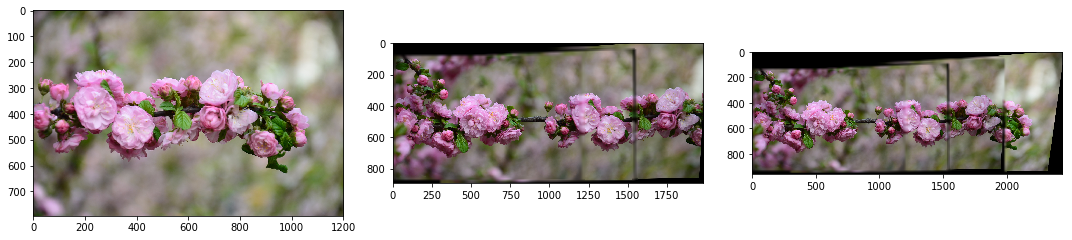

In [11]:
# Root directory of the project
ROOT_DIR = os.getcwd()
# Directory to file 
FILE_DIR = os.path.join(ROOT_DIR, "example-data")

IMAGE_DIR = os.path.join(FILE_DIR,"flower")



file_names = next(os.walk(IMAGE_DIR))[2]
for i in range(len(file_names)):
    for j in range(len(file_names)):
        if file_names[i]<file_names[j]:
            tmp = file_names[i]
            file_names[i]=file_names[j]
            file_names[j]=tmp

image2 = cv2.imread(os.path.join(IMAGE_DIR, file_names[0]))
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
for file in file_names[1:]:
    print(file)
    image1 = cv2.imread(os.path.join(IMAGE_DIR, file))
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = AutoStitch(image1,image2, draw_match=False)
big_image = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
plt.imsave('big.jpg',image2)